# Importing libraries and data

In [10]:
!pip install plotly
!pip install geopy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
# --- Python 
from datetime import datetime

#-- Import DataSet
# from google.colab import files
# uploaded = files.upload()
# import io
# df = pd.read_csv(io.BytesIO(uploaded['kc_house_data.csv']))

df = pd.read_csv('./data/kc_house_data.csv')


 # Exploratory Data Analysis (EDA)

In [11]:
list(df.columns)

['id',
 'date',
 'price',
 'bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'floors',
 'waterfront',
 'view',
 'condition',
 'grade',
 'sqft_above',
 'sqft_basement',
 'yr_built',
 'yr_renovated',
 'zipcode',
 'lat',
 'long',
 'sqft_living15',
 'sqft_lot15']

In [12]:
df.dtypes

id                 int64
date              object
price            float64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
grade              int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
dtype: object

In [13]:
df.isnull().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

# Data Cleaning 

In [14]:
df['bathrooms'] = np.ceil(df['bathrooms']).astype(int)
df['formated_date'] =  df.apply(lambda x: datetime.strptime(x['date'][0:8], '%Y%m%d'), axis=1)

### Calculating price by property area

In [15]:
df['sqft_living_price'] = df['price']/df['sqft_living']
df['sqft_lot_price'] = df['price']/df['sqft_lot']
df['sqft_above_price'] = df['price']/df['sqft_above']
df['sqft_basement_price'] = df['price']/df['sqft_basement']
df['sqft_total'] = df['sqft_basement'] + df['sqft_above']
df['sqft_total_price'] = df['price']/df['sqft_total']
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,long,sqft_living15,sqft_lot15,formated_date,sqft_living_price,sqft_lot_price,sqft_above_price,sqft_basement_price,sqft_total,sqft_total_price
0,7129300520,20141013T000000,221900.0,3,1,1180,5650,1.0,0,0,...,-122.257,1340,5650,2014-10-13,188.050847,39.274336,188.050847,inf,1180,188.050847
1,6414100192,20141209T000000,538000.0,3,3,2570,7242,2.0,0,0,...,-122.319,1690,7639,2014-12-09,209.338521,74.288870,247.926267,1345.000000,2570,209.338521
2,5631500400,20150225T000000,180000.0,2,1,770,10000,1.0,0,0,...,-122.233,2720,8062,2015-02-25,233.766234,18.000000,233.766234,inf,770,233.766234
3,2487200875,20141209T000000,604000.0,4,3,1960,5000,1.0,0,0,...,-122.393,1360,5000,2014-12-09,308.163265,120.800000,575.238095,663.736264,1960,308.163265
4,1954400510,20150218T000000,510000.0,3,2,1680,8080,1.0,0,0,...,-122.045,1800,7503,2015-02-18,303.571429,63.118812,303.571429,inf,1680,303.571429


### Calculating investment profit/loss if the property has been sold more than once in that period

In [16]:
df_1 = df.sort_values(by=['id', 'formated_date'])
df_1.head()
df_1['profit'] = df_1.groupby(['id'])["price"].diff().fillna(0)
df_1.drop_duplicates(
    subset='id',
    keep='last',
    inplace=True
)
df_1 = df_1.sort_values(by=['profit'], ascending=False)
print('rows',len(df_1))

rows 21436


### Function to find the city of each property

In [17]:
# import module
from geopy.geocoders import Nominatim
from geopy.point import Point
# initialize Nominatim API
geolocator = Nominatim(user_agent="geoapiExercises")

def get_city(lat,longitude):
  location =  geolocator.reverse(Point(lat,longitude))
  loc_dict = location.raw
  # print(loc_dict['address'])
  if 'city' in loc_dict['address']:
    return loc_dict['address']['city']
  elif 'town' in loc_dict['address']:
    return loc_dict['address']['town']
  else:
    try:
      item = list(loc_dict.keys())[-7]
      return loc_dict[item]
    except:
      return loc_dict['county']


In [38]:
df_2= df_1[df_1['profit'] != 0]
df_2['city'] = df_2.apply(lambda x: get_city(x['lat'], x['long']) , axis=1)

<ipython-input-38-fbf8254a6836>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2['city'] = df_2.apply(lambda x: get_city(x['lat'], x['long']) , axis=1)


### Top five most profitable

In [19]:
df_2[['id','price','profit','city']].sort_values(by=['profit'], ascending=False).head()

,id,price,profit,city
19336,6021500970,874950.0,529950.0,Seattle
8916,7977201065,740000.0,390000.0,Seattle
3299,7409700215,921500.0,371500.0,Seattle
9280,4443800385,778100.0,368100.0,Seattle
9721,2568300045,649950.0,344950.0,Seattle


### List of most profitable cities

In [20]:
total_profits = df_2.groupby(['city'] , as_index = False).agg({'profit': 'sum' })
total_profits.reset_index(drop=True)
total_profits.sort_values(by=['profit'], ascending=False).head()

,city,profit
18,Seattle,10477879.0
19,Shoreline,2031450.0
3,Burien,1568425.0
15,Renton,1550625.0
1,Bellevue,1163421.0


<AxesSubplot:xlabel='city', ylabel='Count'>

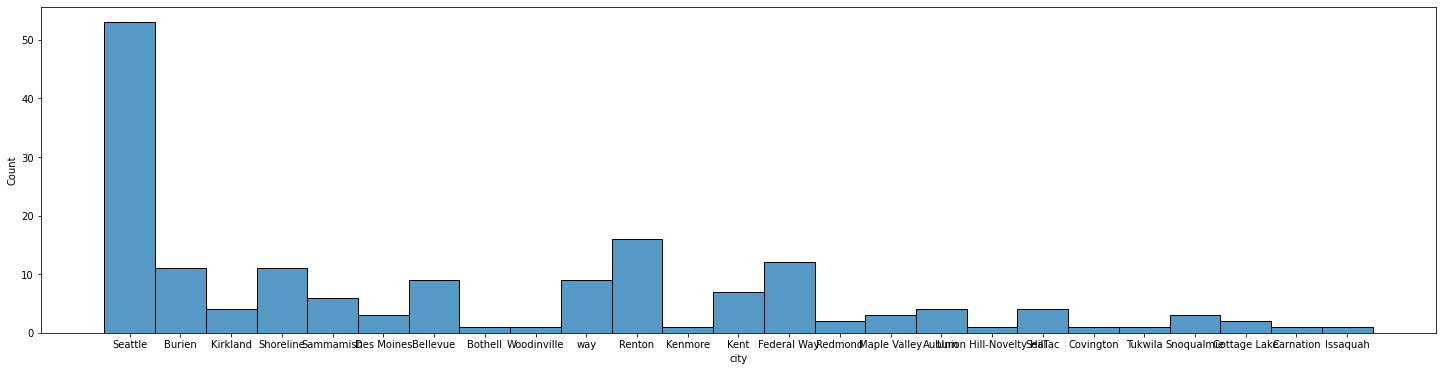

In [21]:
plt.figure(figsize=(25, 6))
sns.histplot(data= df_2[df_2['profit'] > 0] , x="city", binwidth=3)

### we can see that the city that generated the most profit is also the one that has the most profitable properties. The greatest activity in real estate is seen in the city of seattle, so let's focus on the characteristics of properties in that city

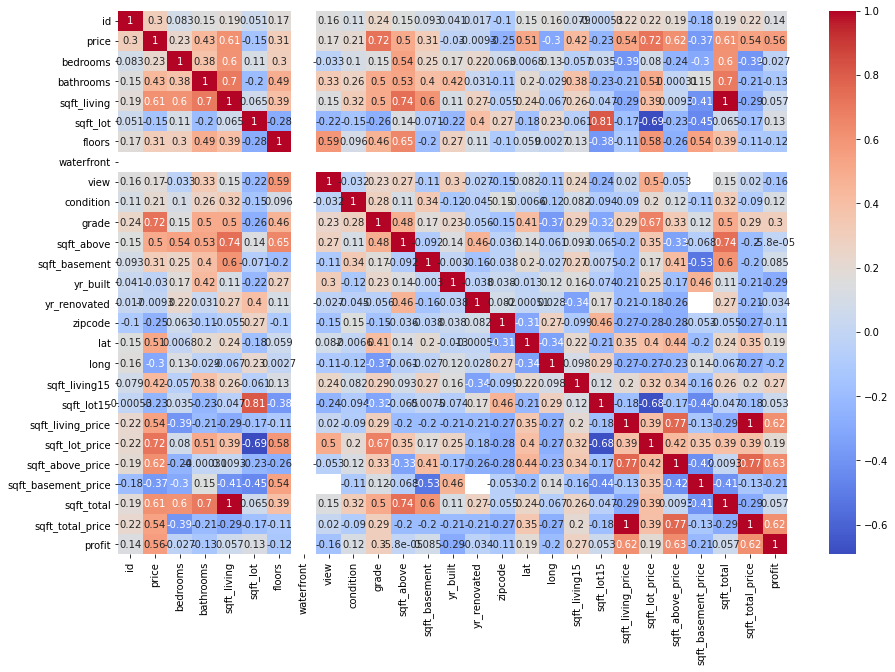

In [22]:
df_best_profit_city = df_2[df_2['city'] == 'Seattle']
df_best_profit_city = df_best_profit_city[df_best_profit_city['profit'] > 0]
plt.figure(figsize=(15, 10))
sns.heatmap(df_best_profit_city.corr(), annot=True, cmap='coolwarm');

### We observe a relationship between profit *(profit)* and price *(price)*, as expected, but we also observe with the price per living square meter *(sqft_living_price)*, which in turn has a direct relationship with the price *(price)*, this in turn with the habitable area *(sqft_liv)*, which in turn is related to the number of bathrooms *(bathrooms)* and bedrooms *(bedrooms)*

<AxesSubplot:xlabel='sqft_living_price', ylabel='profit'>

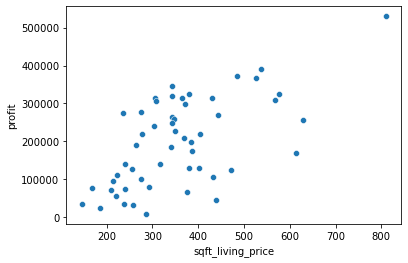

In [23]:
sns.scatterplot(data=df_best_profit_city, x="sqft_living_price", y="profit") 

<AxesSubplot:xlabel='profit', ylabel='price'>

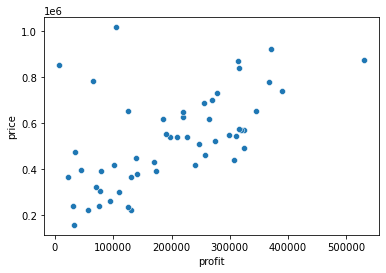

In [24]:
sns.scatterplot(data=df_best_profit_city, x="profit", y="price") 

<AxesSubplot:xlabel='sqft_living', ylabel='price'>

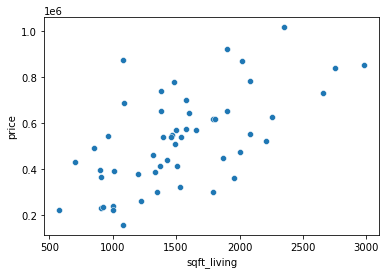

In [25]:
sns.scatterplot(data=df_best_profit_city, x="sqft_living", y="price") 

### We can see a proportional relationship between this data, it is not perfectly linear, prices in the real estate sector depend on many variables and in the end the price adjusts to market demand, but we can use these characteristics to generate a list of recommendations based on on the characteristics of the properties that obtained the highest profit in the area of greatest activity

<AxesSubplot:xlabel='bathrooms', ylabel='Count'>

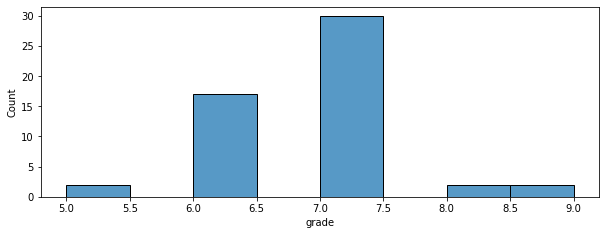

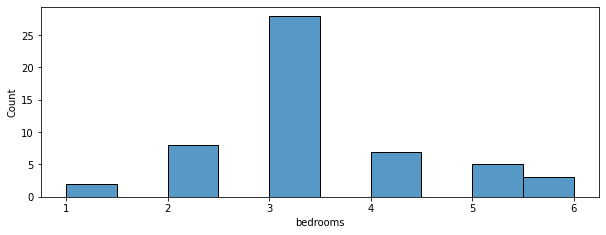

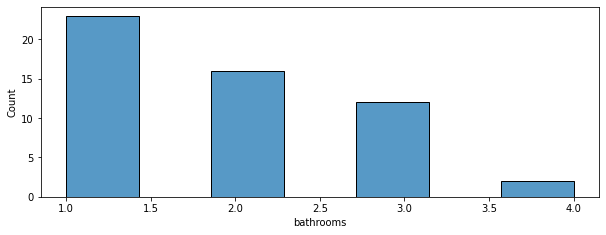

In [26]:
plt.figure(figsize=(10, 3.5))
sns.histplot(data=df_best_profit_city, x="grade" )
plt.figure(figsize=(10, 3.5))
sns.histplot(data=df_best_profit_city, x="bedrooms" )
plt.figure(figsize=(10, 3.5))
sns.histplot(data=df_best_profit_city, x="bathrooms" )

In [27]:
df_best_profit_city[['price','grade','sqft_living','bathrooms', 'bedrooms']].describe()

,price,grade,sqft_living,bathrooms,bedrooms
count,5.300000e+01,53.000000,53.000000,53.000000,53.000000
mean,5.269498e+05,6.716981,1531.698113,1.867925,3.264151
std,2.038492e+05,0.769049,522.500408,0.899524,1.129175
min,1.570000e+05,5.000000,580.000000,1.000000,1.000000
25%,3.890000e+05,6.000000,1090.000000,1.000000,3.000000
50%,5.370000e+05,7.000000,1480.000000,2.000000,3.000000
75%,6.499500e+05,7.000000,1870.000000,3.000000,4.000000
max,1.015000e+06,9.000000,2980.000000,4.000000,6.000000


### As we decided to focus the recommendations on the city of Seattle, and the get_city() function takes a long time to finalize the API queries for the number of properties, we chose to use *zipcode* to filter, this is possible because both the minimum and the The maximum value in the *zipcode* column is four digits, so we can use a web-based list of all four-digit *zipcodes* in Seattle.

In [28]:
print( 'min zipcode' , df_1['zipcode'].min())
print( 'max zipcode' , df_1['zipcode'].max())


# https://zipcodes-us.com/zip/wa/seattle
all_seattle_zipcode=[
    98101, 98102, 98103, 98104, 98105, 98106, 98107, 98108, 98109, 98110, 98111, 98112, 98113, 98114, 98115, 98116, 98117, 98118, 98119, 
    98121, 98122, 98124, 98125, 98126, 98127, 98129, 98131, 98133, 98134, 98136, 98138, 98139, 98141, 98144, 98145, 98146, 98148, 98154, 
    98155, 98158, 98160, 98161, 98164, 98165, 98166, 98168, 98170, 98174, 98175, 98177, 98178, 98181, 98185, 98188, 98190, 98191, 98194, 
    98195, 98198, 98199
]

min zipcode 98001
max zipcode 98199


### filtering the properties based on the characteristics that were observed on average in those that made a profit, It is sorted by price to make a profit at the lowest possible cost

# **Recommended list**

---



In [29]:
df_recommended = df_1[df_1['grade'] == 7]
df_recommended = df_recommended[df_recommended['zipcode'].isin(all_seattle_zipcode)]

price_mean = df_best_profit_city[['price']].describe()['price']['mean']
price_std = df_best_profit_city[['price']].describe()['price']['std']
df_recommended = df_recommended[(df_recommended['price']>= price_mean - price_std) & (df_recommended['price']<= price_mean + price_std )]

sqft_living_price_mean = df_best_profit_city[['sqft_living_price']].describe()['sqft_living_price']['mean']
sqft_living_price_std = df_best_profit_city[['sqft_living_price']].describe()['sqft_living_price']['std']
df_recommended = df_recommended[(df_recommended['sqft_living_price']>= sqft_living_price_mean - sqft_living_price_std) & (df_recommended['sqft_living_price']<= sqft_living_price_mean + sqft_living_price_std )]

sqft_living_mean = df_best_profit_city[['sqft_living']].describe()['sqft_living']['mean']
sqft_living_std = df_best_profit_city[['sqft_living']].describe()['sqft_living']['std']
df_recommended = df_recommended[(df_recommended['sqft_living']>= sqft_living_mean - sqft_living_std) & (df_recommended['sqft_living']<= sqft_living_mean + sqft_living_std )]
                                                                                                                          
df_recommended = df_recommended[df_recommended['bedrooms'] == 3]
df_recommended = df_recommended[df_recommended['bathrooms'] == 2]

print('len(df_recommended)',len(df_recommended))
# df_recommended['city'] = df_recommended.apply(lambda x: get_city(x['lat'], x['long']) , axis=1)
# df_recommended = df_recommended[df_recommended['city'] == 'Seattle']
print(len(df_recommended))
df_recommended[['id','price','grade','bathrooms', 'bedrooms','sqft_living', 'sqft_living_price', 'profit']].sort_values(by=['price'], ascending=True).head()

len(df_recommended) 527
527


,id,price,grade,bathrooms,bedrooms,sqft_living,sqft_living_price,profit
16090,3541700170,324450.0,7,2,3,1420,228.485915,0.0
11814,4364700885,324950.0,7,2,3,1210,268.553719,0.0
7244,3438500168,325000.0,7,2,3,1060,306.603774,0.0
8346,272000355,325000.0,7,2,3,1310,248.091603,0.0
12788,7604400150,329900.0,7,2,3,1380,239.057971,0.0


In [30]:
# df_recommended[['id','price','grade','bathrooms', 'bedrooms','sqft_living', 'sqft_living_price', 'profit']].sort_values(by=['profit'], ascending=False).head()

# Properties with loss

---



<ipython-input-31-b88bd6fee8f3>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_not_recommended['city'] = df_not_recommended.apply(lambda x: get_city(x['lat'], x['long']) , axis=1)


<AxesSubplot:xlabel='city', ylabel='Count'>

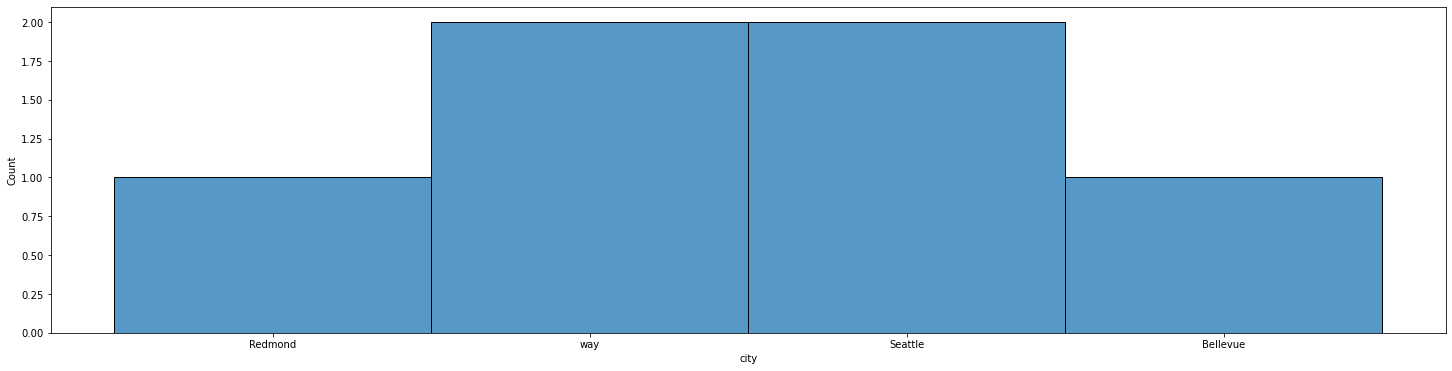

In [31]:
df_not_recommended = df_1[df_1['profit'] < 0]

df_not_recommended['city'] = df_not_recommended.apply(lambda x: get_city(x['lat'], x['long']) , axis=1)
plt.figure(figsize=(25, 6))
sns.histplot(data= df_not_recommended , x="city", binwidth=3)

### We don't have a city with a significantly higher loss volume compared to the others

In [32]:
df_not_recommended[['price','grade','sqft_living','bathrooms', 'bedrooms','profit']].sort_values(by=['profit'], ascending=True).head()

,price,grade,sqft_living,bathrooms,bedrooms,profit
13299,700000.0,10,3350,3,4,-40000.0
5593,489950.0,5,820,1,2,-20050.0
7846,1200000.0,12,4560,4,4,-12500.0
10611,489000.0,8,1290,3,2,-11000.0
837,419950.0,8,1350,2,2,-10050.0


In [33]:
df_not_recommended[['price','grade','sqft_living','bathrooms', 'bedrooms','profit']].sort_values(by=['profit'], ascending=True).head().describe()

,price,grade,sqft_living,bathrooms,bedrooms,profit
count,5.000000e+00,5.000000,5.00000,5.000000,5.000000,5.000000
mean,6.597800e+05,8.600000,2274.00000,2.600000,2.800000,-18720.000000
std,3.197584e+05,2.607681,1606.21605,1.140175,1.095445,12530.592564
min,4.199500e+05,5.000000,820.00000,1.000000,2.000000,-40000.000000
25%,4.890000e+05,8.000000,1290.00000,2.000000,2.000000,-20050.000000
50%,4.899500e+05,8.000000,1350.00000,3.000000,2.000000,-12500.000000
75%,7.000000e+05,10.000000,3350.00000,3.000000,4.000000,-11000.000000
max,1.200000e+06,12.000000,4560.00000,4.000000,4.000000,-10050.000000


### We continue with the same idea of filtering using the characteristics that the data of the properties present, in this case those that suffered losses and we ordered them from the highest to the lowest price, so they would be the 5 highest prices with possible losses.

# Not recommended properties

---



In [34]:
worst_houses = df_not_recommended= df_1[df_1['profit'] < 0]
df_not_recommended = df_1[df_1['grade'] == 9]

price_mean = worst_houses[['price']].describe()['price']['mean']
price_std = worst_houses[['price']].describe()['price']['std']
df_not_recommended = df_not_recommended[(df_not_recommended['price']>= price_mean - price_std) & (df_not_recommended['price']<= price_mean + price_std )]

sqft_living_price_mean = worst_houses[['sqft_living_price']].describe()['sqft_living_price']['mean']
sqft_living_price_std = worst_houses[['sqft_living_price']].describe()['sqft_living_price']['std']
df_not_recommended = df_not_recommended[(df_not_recommended['sqft_living_price']>= sqft_living_price_mean - sqft_living_price_std) & (df_not_recommended['sqft_living_price']<= sqft_living_price_mean + sqft_living_price_std )]

sqft_living_mean = worst_houses[['sqft_living']].describe()['sqft_living']['mean']
sqft_living_std = worst_houses[['sqft_living']].describe()['sqft_living']['std']
df_not_recommended = df_not_recommended[(df_not_recommended['sqft_living']>= sqft_living_mean - sqft_living_std) & (df_not_recommended['sqft_living']<= sqft_living_mean + sqft_living_std )]
                                                                                                                          
df_not_recommended = df_not_recommended[df_not_recommended['bedrooms'] == 3]
df_not_recommended = df_not_recommended[df_not_recommended['bathrooms'] == 3]

print(len(df_not_recommended))
df_not_recommended[['id','price','grade','bathrooms', 'bedrooms','sqft_living', 'sqft_living_price', 'profit']].sort_values(by=['price'], ascending=False).head()


437


,id,price,grade,bathrooms,bedrooms,sqft_living,sqft_living_price,profit
14841,1959700540,952000.0,9,3,3,2450,388.571429,0.0
11263,1102001274,951000.0,9,3,3,3400,279.705882,0.0
19958,5015001452,950000.0,9,3,3,2280,416.666667,0.0
12297,3224500240,950000.0,9,3,3,2750,345.454545,0.0
13846,9241900150,950000.0,9,3,3,3080,308.441558,0.0
